<a href="https://colab.research.google.com/github/DreamTD46/ProjectTump/blob/main/Mastercard_Z1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import swish

In [ ]:
# อ่านข้อมูลจาก CSV
dataset = pd.read_csv(
    "/content/Mastercard_stock_history.csv",
    index_col="Date",
    parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)

tstart = 2016
tend = 2020

In [ ]:
# แบ่งข้อมูลการฝึกและทดสอบ
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)


In [ ]:
# ปรับสเกลข้อมูล
sc = MinMaxScaler(feature_range=(0.3, 0.7))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# ฟังก์ชันการแบ่งข้อมูลออกเป็นลำดับ
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1

In [ ]:
# แบ่งข้อมูลสำหรับการฝึก
X_train, y_train = split_sequence(training_set_scaled, n_steps)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [ ]:
# Define the LSTM model with adjustments
model_lstm = Sequential()
model_lstm.add(Input(shape=(n_steps, features)))
model_lstm.add(LSTM(units=256, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.3))  # Increased dropout to 0.3 for more regularization
model_lstm.add(LSTM(units=128, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=64, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=32, activation="linear", kernel_regularizer=l2(0.001)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

# Early stopping and ReduceLROnPlateau callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', save_best_only=True)

# Train the model
model_lstm.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2,
              callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 0.1309 - val_loss: 0.0487
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 0.0147 - val_loss: 0.0353
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0110 - val_loss: 0.0151
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 0.0088 - val_loss: 0.0059
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0045 - val_loss: 0.0181
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Define the GRU model with adjustments
model_gru = Sequential()
model_gru.add(Input(shape=(n_steps, features)))
model_gru.add(GRU(units=256, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_gru.add(Dropout(0.3))  # Increased dropout to 0.3 for more regularization
model_gru.add(GRU(units=128, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=64, return_sequences=True, activation="swish", kernel_regularizer=l2(0.001)))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=32, activation="linear", kernel_regularizer=l2(0.001)))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

# Early stopping and ReduceLROnPlateau callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
model_gru.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2,
              callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - loss: 0.0901 - val_loss: 0.0450
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0087 - val_loss: 0.0266
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - loss: 0.0073 - val_loss: 0.0154
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - loss: 0.0033 - val_loss: 4.5941e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.0032 - val_loss: 5.7437e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.0029 - val_loss: 4.6109e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0036 - val_loss: 7.4140e-04
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0033 - val_loss: 8.9294e-04
Epoch 12/100
30/3

In [ ]:
# เตรียมข้อมูลสำหรับการทำนาย
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)


In [ ]:
# แบ่งข้อมูลสำหรับการทดสอบ
X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

In [ ]:
# ทำนายด้วยโมเดลทั้งสอง
lstm_predicted_stock_price = model_lstm.predict(X_test)
lstm_predicted_stock_price = sc.inverse_transform(lstm_predicted_stock_price)
gru_predicted_stock_price = model_gru.predict(X_test)
gru_predicted_stock_price = sc.inverse_transform(gru_predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


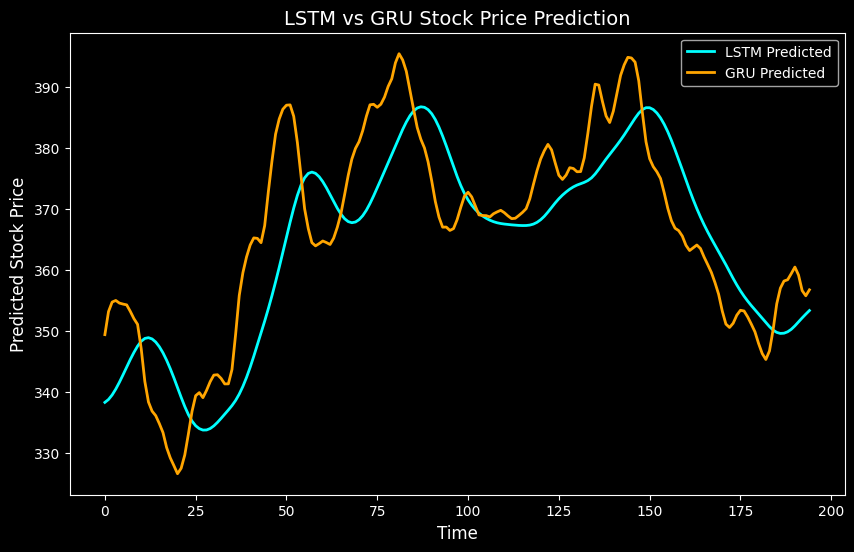

In [ ]:
# ปรับแต่งธีมการแสดงผล
plt.style.use('dark_background')

def plot_lstm_vs_gru(lstm_predicted_stock_price, gru_predicted_stock_price):
    plt.figure(figsize=(10, 6))

    # กราฟการพยากรณ์จาก LSTM
    plt.plot(lstm_predicted_stock_price, color='cyan', label='LSTM Predicted', linewidth=2)

    # กราฟการพยากรณ์จาก GRU
    plt.plot(gru_predicted_stock_price, color='orange', label='GRU Predicted', linewidth=2)

    plt.title('LSTM vs GRU Stock Price Prediction', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Predicted Stock Price', fontsize=12)
    plt.legend(loc='upper right')
    plt.show()

# เรียกใช้ฟังก์ชันนี้เพื่อพล็อตกราฟเปรียบเทียบการพยากรณ์จาก LSTM และ GRU
plot_lstm_vs_gru(lstm_predicted_stock_price=lstm_predicted_stock_price,
                 gru_predicted_stock_price=gru_predicted_stock_price)

In [ ]:
# ฟังก์ชันการแสดงกราฟการทำนายสำหรับโมเดล LSTM และ GRU
def plot_predictions(test, lstm_pred, gru_pred):
    plt.figure(figsize=(14, 7))
    plt.plot(test, color="gray", label="Real")
    plt.plot(lstm_pred, color="red", label="LSTM Predicted")
    plt.plot(gru_pred, color="green", label="GRU Predicted")
    plt.title("MasterCard Stock Price Prediction Comparison")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

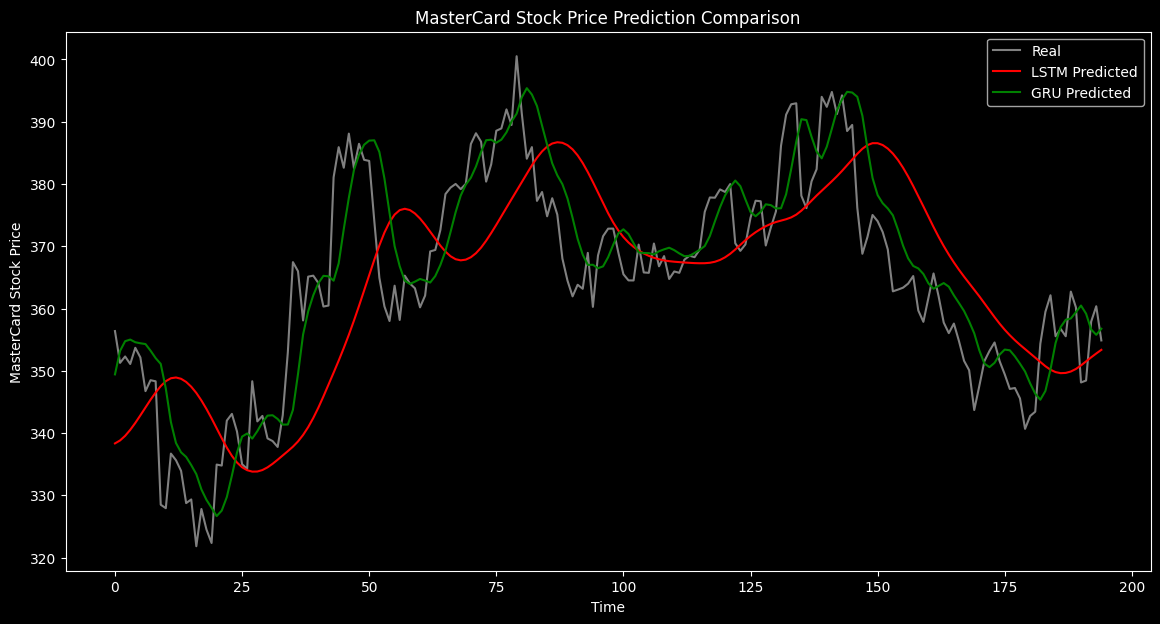

The root mean squared error for LSTM is 13.16.
The root mean squared error for GRU is 7.80.


In [ ]:
# ฟังก์ชันการคำนวณ RMSE
def return_rmse(test, predicted, model_name):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error for {model_name} is {rmse:.2f}.")

plot_predictions(test_set, lstm_predicted_stock_price, gru_predicted_stock_price)
return_rmse(test_set, lstm_predicted_stock_price, "LSTM")
return_rmse(test_set, gru_predicted_stock_price, "GRU")